# CISA KVE EPSS Data Analyis 

In [1]:
import pandas as pd
import json
import requests
import os
import glob
import numpy as np

In [2]:
cisa_df = pd.read_csv("https://www.cisa.gov/sites/default/files/csv/known_exploited_vulnerabilities.csv")
cisa_df = cisa_df
cisa_df.columns = cisa_df.columns.str.strip("\u200b")
cisa_df = cisa_df.rename(columns={"cveID": "CVE", "shortDescription" : "Description", "dateAdded" : "Date"})

In [3]:
epss = pd.read_csv('epss_scores-current.csv', skiprows=1)
epss = epss.rename(columns={"cve": "CVE", "epss" : "EPSS", "percentile" : "EPSS Percentile"})

In [4]:
row_accumulator = []
for filename in glob.glob('nvdcve-2.0-*.json'):
    with open(filename, 'r', encoding='utf-8') as f:
        nvd_data = json.load(f)
        for entry in nvd_data['vulnerabilities']:
            cve = entry['cve']['id']
            try:
                base_score = entry['cve']['metrics']['cvssMetricV31'][0]['cvssData']['baseScore']
            except KeyError:
                base_score = '0.0'
            new_row = { 
                'CVE': cve, 
                'CVSS3': base_score,
            }
            row_accumulator.append(new_row)
        nvd = pd.DataFrame(row_accumulator)
        
nvd['CVSS3'] = pd.to_numeric(nvd['CVSS3']);
nvd['CVSS3'] = nvd['CVSS3'].replace(0, np.nan);       

In [5]:
epss_kev = pd.merge(cisa_df, epss, left_on='CVE', right_on='CVE')
epss_kev_nvd =  pd.merge(epss_kev, nvd, left_on='CVE', right_on='CVE')
epss_kev_nvd =  epss_kev_nvd[["CVE", "CVSS3", "EPSS", "EPSS Percentile", "Description", "Date"]]

## CISA KEV Score Scatter Plot

Matplotlib is building the font cache; this may take a moment.


/opt/hostedtoolcache/Python/3.10.19/x64/lib/python3.10/site-packages/pandas/plotting/_matplotlib/core.py:1351: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  scatter = ax.scatter(


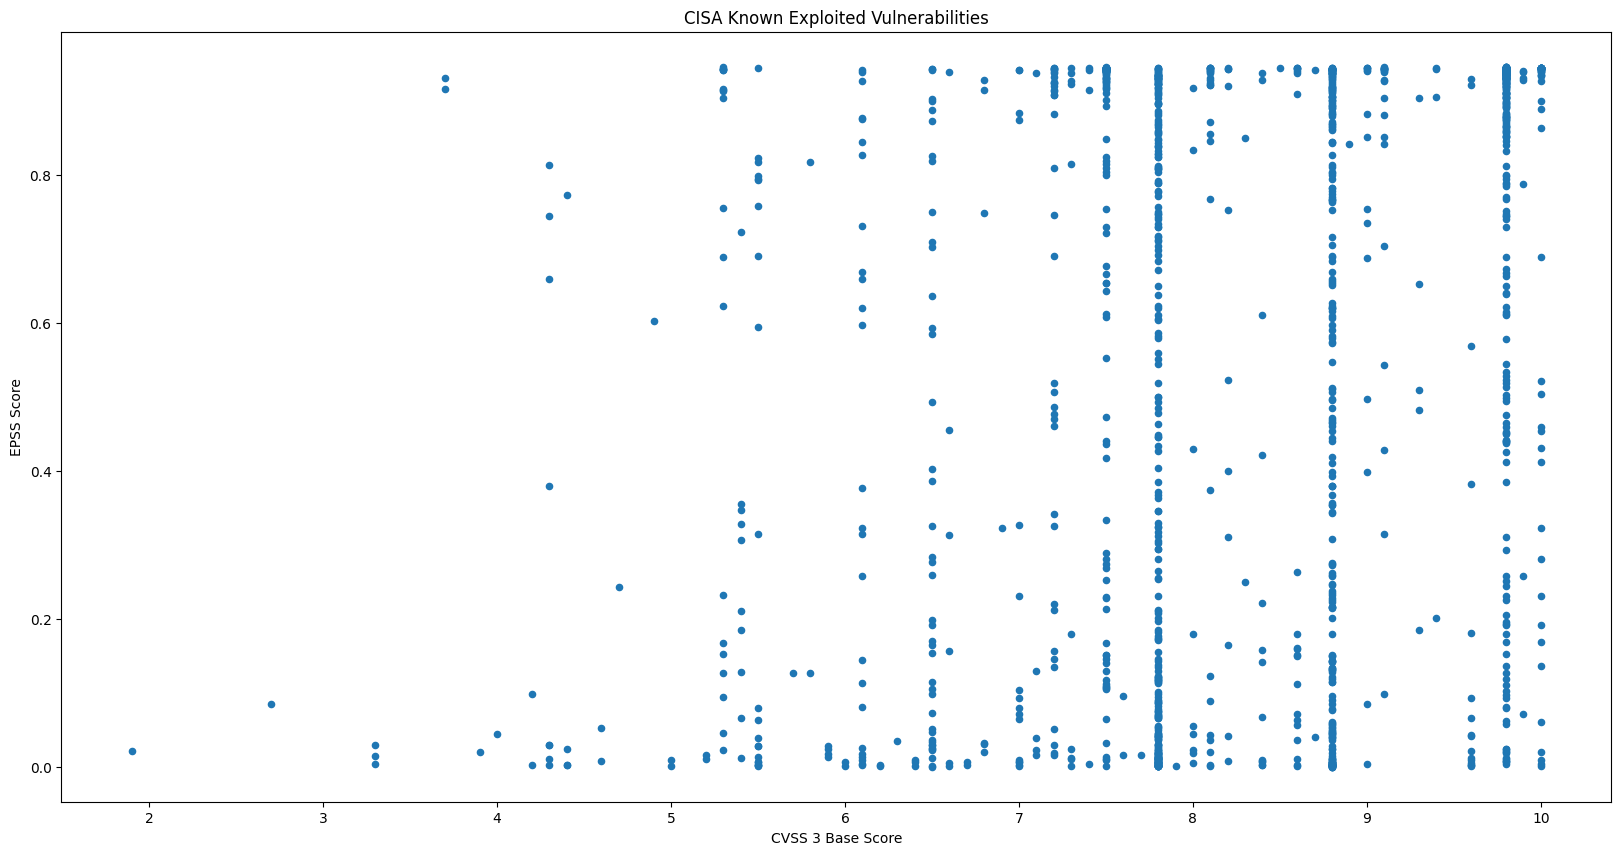

In [6]:
ax = epss_kev_nvd.plot.scatter(x='CVSS3',
                     y='EPSS',
                     colormap='jet',
                     figsize=(20, 10),
                     title='CISA Known Exploited Vulnerabilities');
ax.set_xlabel("CVSS 3 Base Score");
ax.set_ylabel("EPSS Score");
ax.figure.savefig('epss_kev_nvd.png');

## Export to CSV

In [7]:
epss_kev_nvd.to_csv("epss_kev_nvd.csv", index=False)
epss_kev_nvd.head(10)

,CVE,CVSS3,EPSS,EPSS Percentile,Description,Date
0,CVE-2021-26828,8.8,0.84324,0.99267,OpenPLC ScadaBR contains an unrestricted uploa...,2025-12-03
1,CVE-2021-26829,5.4,0.32792,0.96688,OpenPLC ScadaBR contains a cross-site scriptin...,2025-11-28
2,CVE-2025-61757,9.8,0.79446,0.99024,Oracle Fusion Middleware contains a missing au...,2025-11-21
3,CVE-2025-13223,8.8,0.05835,0.90178,Google Chromium V8 contains a type confusion v...,2025-11-19
4,CVE-2025-58034,7.2,0.48612,0.97612,Fortinet FortiWeb contains an OS command Injec...,2025-11-18
5,CVE-2025-64446,9.8,0.85192,0.99309,Fortinet FortiWeb contains a relative path tra...,2025-11-14
6,CVE-2025-12480,9.1,0.70360,0.98614,Gladinet Triofox contains an improper access c...,2025-11-12
7,CVE-2025-62215,7.0,0.00594,0.68408,Microsoft Windows Kernel contains a race condi...,2025-11-12
8,CVE-2025-9242,9.8,0.74370,0.98781,WatchGuard Firebox contains an out-of-bounds w...,2025-11-12
9,CVE-2025-21042,8.8,0.03976,0.87963,Samsung mobile devices contain an out-of-bound...,2025-11-10
